<h1>Classifying European Money Denominations: Training a Pre-trained model  </h1>

In [1]:
import torch 
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)

import numpy as np
import pandas as pd
import time
from imageio import imread
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image, ImageDraw, ImageFont
import random

<hr>

<h2 id="gen">Create Dataset Class and Object</h2>

In [2]:
# Url that contains CSV files

train_csv_file = './data/training_labels.csv'
validation_csv_file = './data/validation_labels.csv'

In [3]:
# The directory contains image datasets

train_data_dir = './data/training_data_pytorch/'
validation_data_dir = './data/validation_data_pytorch/'

In [4]:
# Create Dateaset Class

class Dataset(Dataset):

    # Constructor
    def __init__(self, csv_file, data_dir, transform=None):
        
        # Image directory
        self.data_dir=data_dir
        
        # The transform is goint to be used on image
        self.transform = transform
        
        # Load the CSV file contians image info
        self.data_name= pd.read_csv(csv_file)
        
        # Number of images in dataset
        self.len=self.data_name.shape[0] 
    
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        # Image file path
        img_name=self.data_dir + self.data_name.iloc[idx, 2]
        
        # Open image file
        image = Image.open(img_name)
        
        # The class label for the image
        y = self.data_name.iloc[idx, 3]
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

In [5]:
# Construct the composed object for transforming the image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
composed = transforms.Compose([transforms.Resize((224, 224))
                               , transforms.ToTensor()
                               , transforms.Normalize(mean, std)])

In [6]:
# Create the train dataset and validation dataset

train_dataset = Dataset(transform=composed,
                        csv_file=train_csv_file,
                        data_dir=train_data_dir)

validation_dataset = Dataset(transform=composed,
                          csv_file=validation_csv_file,
                          data_dir=validation_data_dir)

<hr>

<h2>Models</h2>

In [7]:
# Load the pre-trained model resnet18

model = models.resnet18(pretrained=True)

In [8]:
# Set the parameter cannot be trained for the pre-trained model

for param in model.parameters():
    param.requires_grad=False
    
# Re-defined the last layer to 7 classes (last hidden layer has 512 neurons)

model.fc = nn.Linear(512,7)

# Print the model 

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h3>Train the model <code>Resnet18</code> to do the prediction</h3>

<b>Step 1</b>: Create a cross entropy criterion function 

In [9]:
# Create the loss function

criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size is <i>15</i> and <i>10</i> respectively .

In [10]:
# Create the data loader

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=15)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=10)

<b>Step 3</b>: Use the following optimizer to minimize the loss 

In [11]:
# Use the pre-defined optimizer Adam with learning rate 0.003

optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=0.003)

<b>Step 4</b>: Train the model for 20 epochs, save the loss in a list as will as the accuracy on the validation data for every epoch. The entire process may take 6.5 minutes. Print the validation accuracy for each epoch during the epoch loop. Then, plot the training loss for each epoch and validation error for each epoch.

In [12]:
# Train the model

N_EPOCHS = 20
loss_list = []
accuracy_list = []
correct = 0
n_test = len(validation_dataset)

for epoch in range(N_EPOCHS):
    loss_sublist=[]
    for x,y in train_loader:
        model.train()
        optimizer.zero_grad()
        z=model(x)
        loss=criterion(z,y)
        loss_sublist.append(loss.data.item())
        loss.backward()
        optimizer.step()
    loss_list.append(np.mean(loss_sublist))
    
    correct=0
    for x_test, y_test in validation_loader:
        model.eval()
        z=model(x_test)
        _,yhat=torch.max(z.data,1)
        correct+=(yhat==y_test).sum().item()
    accuracy=correct/n_test
    accuracy_list.append(accuracy)
    
    print("Epoch: {}/{}".format(epoch+1,N_EPOCHS))
    
print(accuracy)

Epoch: 1/20
Epoch: 2/20
Epoch: 3/20
Epoch: 4/20
Epoch: 5/20
Epoch: 6/20
Epoch: 7/20
Epoch: 8/20
Epoch: 9/20
Epoch: 10/20
Epoch: 11/20
Epoch: 12/20
Epoch: 13/20
Epoch: 14/20
Epoch: 15/20
Epoch: 16/20
Epoch: 17/20
Epoch: 18/20
Epoch: 19/20
Epoch: 20/20


<b>Step 5</b>: Plot the training loss for each iteration<br>

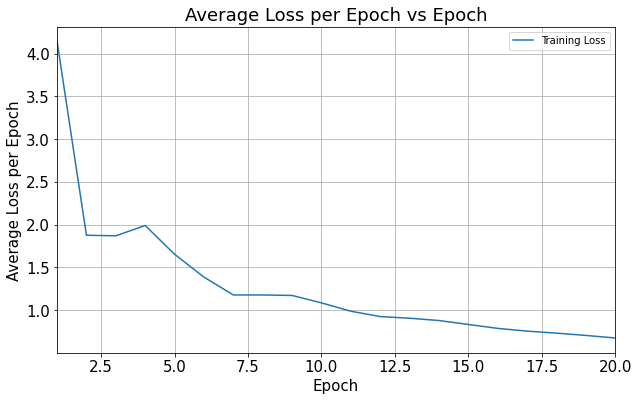

In [13]:
# Plot the loss for training dataset

plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS+1), loss_list, label = "Training Loss")
plt.legend()
plt.xlabel('Epoch', fontsize=15);
plt.ylabel('Average Loss per Epoch', fontsize=15);
plt.title("Average Loss per Epoch vs Epoch", fontsize=18);
plt.grid(True)
plt.xlim(1, N_EPOCHS);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

<b>Step 6</b>: Plot the validation accuracy for each epoch<br>

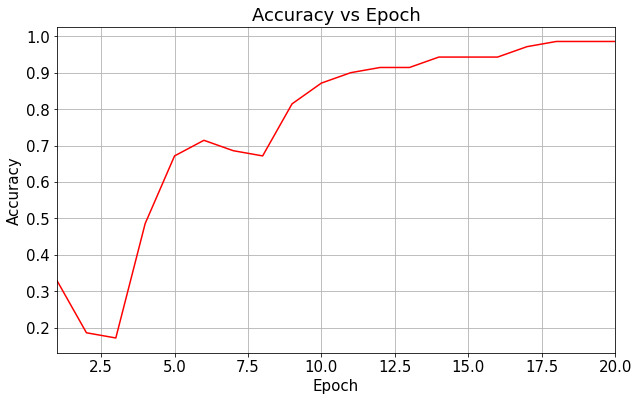

In [14]:
# Plot the accuracy for valdiation dataset

plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS+1), accuracy_list, "r")
plt.xlabel('Epoch', fontsize=15);
plt.ylabel('Accuracy', fontsize=15);
plt.title("Accuracy vs Epoch", fontsize=18);
plt.grid(True)
plt.xlim(1, N_EPOCHS);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

<h3>Plot 5 Random Images with their predictions</h3>

In [15]:
# Plot the images with labels

look_up = {0: 'predicted: $5',
           1: 'predicted: $10',
           2: 'predicted: $20',
           3: 'predicted: $50',
           4: 'predicted: $100',
           5: 'predicted $200',
           6: 'predicted $500'}
random.seed(0)
numbers = random.sample(range(70), 5)

# Type your code here
test_dataset = Dataset(transform=composed,
                          csv_file=validation_csv_file,
                          data_dir=validation_data_dir)

test_loader=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=5)
correct=0

for x,y in test_loader:
    model.eval()
    z=model(x_test)
    _,yhat=torch.max(z.data, 1)
    correct+=(yhat==y_test).sum().item()


In [16]:
def image_loader(image_name):
    image=Image.open(image_name)
    image=composed(image).float()
    #image=Variable(image,requires_grad=True)
    image=image.unsqueeze(0)
    return image

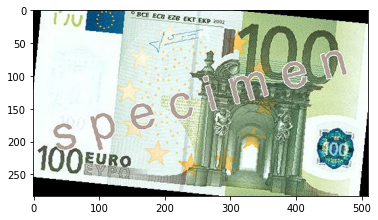

predicted: $100 (Correctly classified)


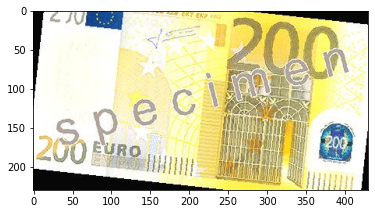

predicted $200 (Correctly classified)


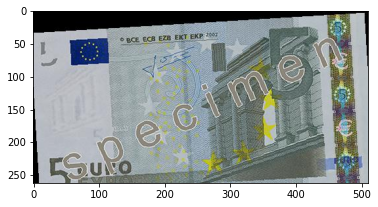

predicted: $5 (Correctly classified)


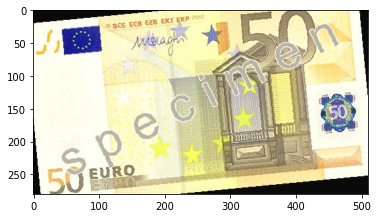

predicted: $50 (Correctly classified)


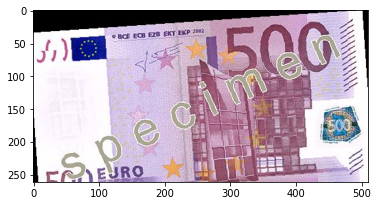

predicted $500 (Correctly classified)


In [17]:
validation_data_name = pd.read_csv(validation_csv_file)
    
for i in range(5):
    
    validation_image_name = validation_data_dir + validation_data_name.iloc[numbers[i],2]
    image=Image.open(validation_image_name)
    plt.imshow(image)
    plt.show()
    image=image_loader(validation_image_name)
    model(image)
    
    preds=nn.LogSoftmax(dim=1)(model(image)).data.cpu().numpy()
    res=np.argmax(preds)
    print(look_up[res] + ' (Correctly classified)')

<h3>Train the second model <code>Densenet121</code> to do the prediction</h3>

In [18]:
# Use densenet121 to train the model and print out the last validation accuracy.

model_des=models.densenet121(pretrained=True)

for param in model_des.parameters():
    param.requires_grad=False
    
model_des.classifier=nn.Linear(1024, 7)

print(model_des)
criterion=nn.CrossEntropyLoss()

train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=15)
validation_loader=torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=10)

optimizer=torch.optim.Adam([parameters for parameters in model_des.parameters() if parameters.requires_grad], lr=0.003)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [19]:
N_EPOCHS = 10
loss_list = []
accuracy_list = []
correct = 0
n_test = len(validation_dataset)

for epoch in range(N_EPOCHS):
    loss_sublist=[]
    for x,y in train_loader:
        model_des.train()
        optimizer.zero_grad()
        z=model_des(x)
        loss=criterion(z,y)
        loss_sublist.append(loss.data.item())
        loss.backward()
        optimizer.step()
    loss_list.append(np.mean(loss_sublist))
    
    correct=0
    for x_test, y_test in validation_loader:
        model_des.eval()
        z=model_des(x_test)
        _,yhat=torch.max(z.data, 1)
        correct+=(yhat==y_test).sum().item()
    accuracy=correct/n_test
    accuracy_list.append(accuracy)
    print("Epoch: {}/{}".format(epoch+1, N_EPOCHS))
    
print(accuracy)

Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
Epoch: 10/10
0.9857142857142858


<h2>Save the trained models</h2>

In [20]:
# Save the model

torch.save(model, "resnet18_pytorch.pt")
torch.save(model_des, "densenet121_pytorch.pt")